In [755]:
import os
import copy
import matplotlib.pyplot as plt
import random 
import PIL.Image as Image
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
import torchvision.transforms as T
from typing import *

In [756]:
test_image = os.path.join('..','data','down-stream','binary','Normal','1.jpg')

In [757]:
test_image = Image.open(test_image)

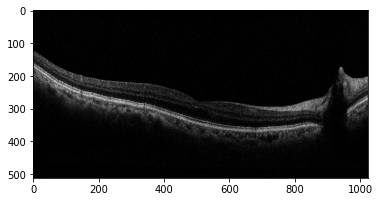

In [758]:
plt.imshow(test_image)

In [759]:
transforms = T.Compose([T.Resize((224,224)),
                        T.RandomApply([T.ColorJitter(0.8,0.8,0.8,0.2)], p=0.8),
                        T.RandomGrayscale(p=0.2),
                        T.RandomHorizontalFlip(p=0.5),
                        T.RandomApply([T.GaussianBlur(kernel_size=(3,3), sigma=(1.5,1.5))], p=0.1),
                        T.RandomResizedCrop(size=(224,224)),
                        T.ToTensor(),
                        T.Normalize(mean=torch.tensor([0.485, 0.456, 0.406]), 
                                    std= torch.tensor([0.229, 0.224, 0.225]))
                        ])

In [760]:
test_image = transforms(test_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


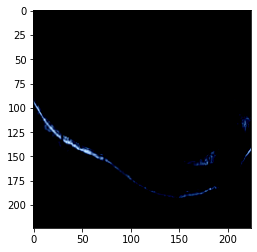

In [761]:
plt.imshow(test_image.permute((1,2,0)))

In [762]:
test_image = test_image.unsqueeze(0)

In [763]:
class MLP(nn.Module):
    def __init__(self,
                 input_dim: int,
                 projection_dim: int = 256,
                 hidden_dim: int = 4096
                ) -> None:
        super(MLP,self).__init__()
    
        self.mlp = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                 nn.BatchNorm1d(hidden_dim),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(hidden_dim, projection_dim)
        
        )
    
    def forward(self, x: Tensor) -> Tensor:
        return self.mlp(x)

In [764]:
model = MLP(input_dim=1024, projection_dim=256, hidden_dim=4096)
x= torch.randn(2,1024)
model(x).shape


torch.Size([2, 256])

In [1022]:
class NormalizedMSELoss(nn.Module):
    def __init__(self) -> None:
        super(NormalizedMSELoss,self).__init__()
        
        
        
    def _forward(self, 
                 view1: Tensor , 
                 view2: Tensor
                ) -> Tensor:
        
        view1 = F.normalize(view1, p=2, dim=-1)
        view2 = F.normalize(view2, p=2, dim=-1)
        loss = 2 - 2 * (view1 * view2).sum(dim=-1)
        return loss
    
    def forward(self, 
                v1_online_pred: Tensor,
                v2_target_proj: Tensor,
                v2_online_pred: Tensor,
                v1_target_proj: Tensor
               ) -> Tensor:
        
        loss1 = self._forward(v1_online_pred,v2_target_proj)
        loss2 = self._forward(v2_online_pred,v1_target_proj)
        
        loss = loss1 + loss2
        
        return loss.mean()
        

        


In [1015]:
x = torch.tensor([1.,2.,626.])
y = torch.tensor([77.,95.,6.])
z = torch.tensor([325.,8.,9.])
w = torch.tensor([155.,1125.,12.])

In [1016]:
loss = MSELoss()
print(loss(x,y,z,w))


tensor(3.5729)


In [768]:
class EMA:
    def __init__(self,
                target_decay: float
                ) -> None:
        self.target_decay = target_decay
        
        assert 0 <= self.target_decay <= 1, 'target decay must bet between [0-1] inclusive'
        
    def __call__(self,
                 online_weights: Tensor,
                 target_weights: Tensor
                ) -> Tensor:
        
        return target_weights * self.target_decay + (1 - self.target_decay) * online_weights

In [769]:
moving_avg = EMA(target_decay=0.5)

In [770]:
moving_avg(x,y)

tensor([1.0500, 2.0500, 3.0500])

In [771]:
class EncodProject(nn.Module):
    def __init__(self,
                 model: nn.Module,
                 hidden_dim: int = 4096,
                 projection_out_dim: int = 256
                 ) -> None:
        super(EncodProject, self).__init__()
                
        self.encoder = nn.Sequential(*list(model.children())[:-1])
        self.projector = MLP(input_dim= nn.Sequential(*list(model.children()))[-1].in_features,
                             projection_dim=projection_out_dim,
                             hidden_dim= hidden_dim)

    def forward(self, x: Tensor) -> Tensor:
        x = self.encoder(x)
        x = torch.flatten(x, 1)
        x = self.projector(x)
        return x

In [772]:
model = EncodProject(resnet18())
model(torch.rand(2,3,224,224)).shape


# from torchsummary import summary
# summary(model,(3,224,224))



torch.Size([2, 256])

In [1020]:
class BYOL(nn.Module):
    def __init__(self,
                 model: nn.Module,
                 hidden_dim: int = 4096,
                 projection_out_dim: int = 256,
                 target_decay: float = 0.99
                 
                ) -> None:
        super(BYOL, self).__init__()
        
        self.online_encoder = EncodProject(model=model,
                                           hidden_dim=hidden_dim,
                                           projection_out_dim=projection_out_dim
                                          ) 
        self.online_predictor = MLP(input_dim=projection_out_dim,
                                    hidden_dim=hidden_dim,
                                    projection_dim=projection_out_dim
                                   )

        self.target_network = copy.deepcopy(self.online_encoder)
        self._set_requieres_grad(self.target_network, False)
        
        self.moving_average_updater = EMA(target_decay=target_decay)

    
    def _set_requieres_grad(self,
                            model: nn.Module,
                            grad: bool = False
                           ) -> None:
        for param in model.parameters():
            param.requires_grad = grad
          
        
    def update_target_network(self) -> None:
        for online_weights, target_weights in zip(self.online_encoder.parameters(), 
                                                  self.target_network.parameters()
                                                 ):
            target_weights.data = self.moving_average_updater(online_weights=online_weights.data,
                                                              target_weights=target_weights.data)
            

        
    def forward(self, 
                view1, 
                view2
               ) -> Tuple[Tensor]:
        
        view1_online_projection = self.online_encoder(view1)
        view1_online_prediction = self.online_predictor(view1_online_projection)
        
        view2_online_projection = self.online_encoder(view2)
        view2_online_prediction = self.online_predictor(view2_online_projection)
        
        with torch.no_grad():
            view1_target_projection = self.target_network(view1)        
            view2_target_projection = self.target_network(view2)
            view1_target_projection.detach_()
            view2_target_projection.detach_()
        
        
        

        return (view1_online_prediction,
                view2_target_projection.detach_(),
                view2_online_prediction,
                view1_target_projection.detach_())
                
        
        

In [779]:
class SimpleNet(nn.Module):
    def __init__(self, 
                 clf: bool = True,
                ) -> None:
        super(SimpleNet,self).__init__()
        
        self.clf = clf
        
        
        self.conv1 = nn.Conv2d(3,32,3,2,1)
        self.max_pool1 = nn.MaxPool2d(2) 
        self.avg_pool1 = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(32,2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.max_pool1(x)
        x = self.avg_pool1(x)
        x = torch.flatten(x, 1)
        if self.clf:
            
            x = self.fc1(x)
        return x

In [ ]:
from torchvision.models import resnet18

model = resnet18()

learner = BYOL(model)

opt = torch.optim.Adam(learner.parameters(), lr=3e-4)

criterion = NormalizedMSELoss()

def sample_unlabelled_images():
    return torch.randn(20, 3, 256, 256)

for _ in range(100):
    images1 = sample_unlabelled_images()
    images2 = sample_unlabelled_images() * 0.9
    v1_on, v2_tar, v2_on, v1_tar = learner(images1, images2)
    loss = criterion(v1_on, v2_tar, v2_on, v1_tar)
    opt.zero_grad()
    loss.backward()
    opt.step()
    learner.update_target_network()
    print(loss)

tensor(3.8455, grad_fn=<MeanBackward0>)
tensor(2.5038, grad_fn=<MeanBackward0>)
tensor(2.1395, grad_fn=<MeanBackward0>)
tensor(2.0375, grad_fn=<MeanBackward0>)
tensor(1.9862, grad_fn=<MeanBackward0>)
tensor(1.9475, grad_fn=<MeanBackward0>)
tensor(1.9186, grad_fn=<MeanBackward0>)
tensor(1.9324, grad_fn=<MeanBackward0>)
tensor(1.9099, grad_fn=<MeanBackward0>)
tensor(1.8983, grad_fn=<MeanBackward0>)
tensor(1.8845, grad_fn=<MeanBackward0>)
tensor(1.8671, grad_fn=<MeanBackward0>)
tensor(1.8672, grad_fn=<MeanBackward0>)
tensor(1.8632, grad_fn=<MeanBackward0>)
tensor(1.8634, grad_fn=<MeanBackward0>)
tensor(1.8958, grad_fn=<MeanBackward0>)
tensor(1.8684, grad_fn=<MeanBackward0>)
tensor(1.8830, grad_fn=<MeanBackward0>)
tensor(1.8541, grad_fn=<MeanBackward0>)
tensor(1.8474, grad_fn=<MeanBackward0>)
tensor(1.8509, grad_fn=<MeanBackward0>)
tensor(1.8402, grad_fn=<MeanBackward0>)
tensor(1.8663, grad_fn=<MeanBackward0>)
tensor(1.8372, grad_fn=<MeanBackward0>)
tensor(1.8594, grad_fn=<MeanBackward0>)
